## Análise de Carga de Trabalho da Máquina

Caso deseje conhecer todo o processo de tratamento ETL do conjunto de dados acesse o notebook [Extração, Transformação e Carga](extract_transform_load.ipynb).

In [85]:
# Exibe o conjunto de dados da máquina tratada
import pandas as pd

def dataframe(file):
    df = pd.read_csv(file)
    df.time_stamp = pd.to_datetime(df.time_stamp)
    df.set_index('time_stamp', inplace=True)
    return df

dataframe('loaded_m_3330.csv')

,cpu,mem
time_stamp,,
1970-01-01 00:00:00,17.0,92.0
1970-01-01 00:05:00,20.0,92.0
1970-01-01 00:10:00,34.0,95.0
1970-01-01 00:15:00,27.0,93.0
1970-01-01 00:20:00,33.0,95.0
...,...,...
1970-01-08 23:35:00,21.0,89.0
1970-01-08 23:40:00,25.0,90.0
1970-01-08 23:45:00,19.0,88.0


<AxesSubplot:xlabel='time_stamp'>

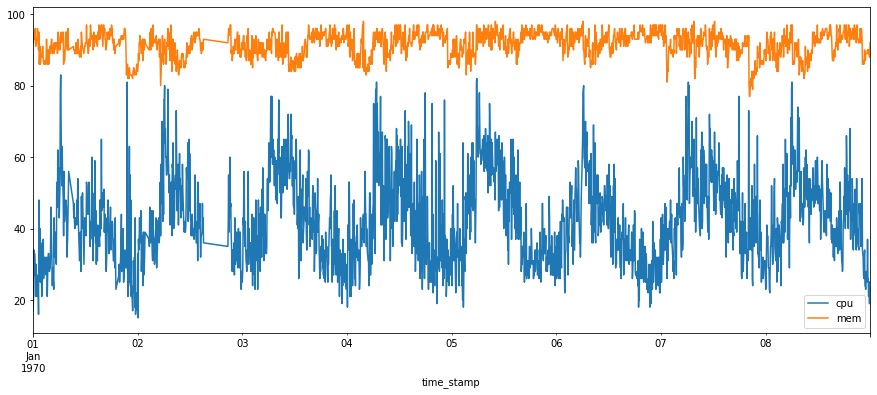

In [87]:
# Plota os dados
dataframe('loaded_m_3330.csv').plot(figsize=(15,6))

Text(0.5, 0, 'tempo')

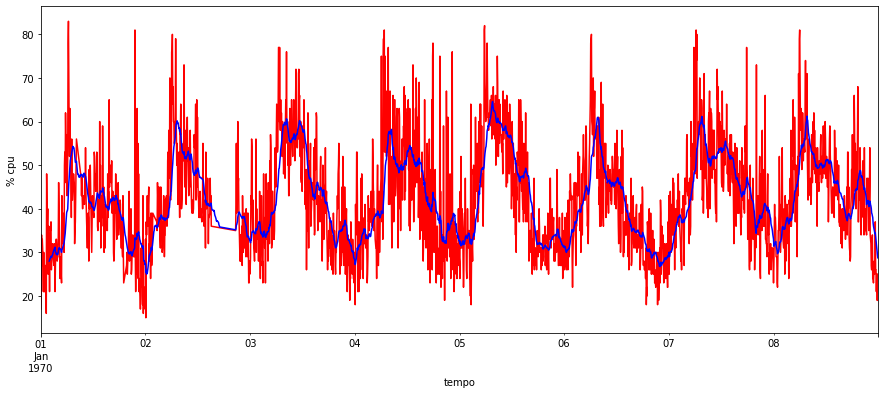

In [91]:
# Média Móvel da CPU
import matplotlib.pyplot as plt
df = dataframe('loaded_m_3330.csv')
df['cpu_sma'] = df.cpu.rolling(24).mean()
df.cpu.plot(figsize=(15,6), color = ['red'])
df.cpu_sma.plot(color = ['blue'])
plt.ylabel('% cpu')
plt.xlabel('tempo')

Text(0.5, 0, 'tempo')

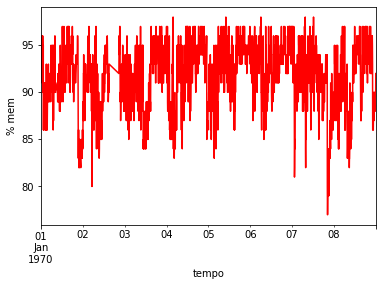

In [39]:
import matplotlib.pyplot as plt
df = dataframe('loaded_m_3330.csv')
df.mem.plot(color = ['red'])
plt.ylabel('% mem')
plt.xlabel('tempo')

In [55]:
# Erro médio quadrático do modelo AR
from statsmodels.tsa.ar_model import AR

def emq(serie, order):
    train_size = int(len(serie) * 2/3)
    train_set = serie[:train_size]
    test_set = serie[train_size:]

    model = AR(train_set, freq='5T').fit(order)
    model.params

    previsao = model.params[0]
    for i, coef in enumerate(model.params[1:]):
        previsao += coef * test_set.shift(i + 1)
    return ((test_set - previsao) ** 2).mean()
emq(dataframe('loaded_m_3330.csv').cpu,1)

70.95945561754723

In [41]:
# Modelo Auto Regressivo (AR)
import time
from statsmodels.tsa.ar_model import AR

def ar_model(serie, order):
    orders = range(1, order**2+1)
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            error = emq(serie, order)
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('AR', f'({order})', error, proc_time)
        except:
            pass
    print({'model':'AR', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'AR', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
ar_model(dataframe('loaded_m_3330.csv').cpu,1)

AR (1) 70.95945561754723 0.00973057746887207
{'model': 'AR', 'best_order': 1, 'best_error': 70.95945561754723, 'best_time': 0.00973057746887207}


{'model': 'AR',
 'best_order': 1,
 'best_error': 70.95945561754723,
 'best_time': 0.00973057746887207,
 'order_list': [1],
 'error_list': [70.95945561754723],
 'proc_time_list': [0.00973057746887207]}

In [56]:
# Modelo Auto Regressivo de Médias Móveis (ARMA)
import time
from statsmodels.tsa.arima_model import ARMA
    
def arma_model(serie, order):
    
    orders = [(p+1, q+1) for p in range(order) for q in range(order)] #[(1,1), (2,1), (1,2), (3,1), (3,2), (3,3), (4,1), (4,2), (4,3), (4,4), (5,1), (5,2), (5,3), (5,4), (5,5)]
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            model = ARMA(serie, freq='5T', order=order).fit()
            error = (model.resid ** 2).mean()
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('ARMA', order, error, proc_time)
        except:
            pass
    print({'model':'ARMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'ARMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
arma_model(dataframe('loaded_m_3330.csv').cpu,1)

ARMA (1, 1) 69.3971872939303 0.8066983222961426
{'model': 'ARMA', 'best_order': (1, 1), 'best_error': 69.3971872939303, 'best_time': 0.8066983222961426}


{'model': 'ARMA',
 'best_order': (1, 1),
 'best_error': 69.3971872939303,
 'best_time': 0.8066983222961426,
 'order_list': [(1, 1)],
 'error_list': [69.3971872939303],
 'proc_time_list': [0.8066983222961426]}

In [83]:
# Modelo Auto Regressivo Integrado de Médias Móveis (ARIMA)
import time
from statsmodels.tsa.arima_model import ARIMA
    
def arima_model(serie, order):

    orders = [(p+1, 1, q+1) for p in range(order) for q in range(order)] #[(1,1,1), (2,1,1), (1,1,2), (3,1,1), (3,1,2), (3,1,3), (4,1,1), (4,1,2), (4,1,3), (4,1,4), (5,1,1), (5,1,2), (5,1,3), (5,1,4), (5,1,5)]
    best_error = 100000
    order_list = []
    error_list = []
    proc_time_list = []
    for order in orders:
        start_time = time.time()
        try:
            model = ARIMA(serie, freq='5T', order=order).fit()
            error = (model.resid ** 2).mean()
            order_list.append(order)
            error_list.append(error)
            proc_time = time.time() - start_time
            proc_time_list.append(proc_time)
            
            if error < best_error:
                best_error = error
                best_order = order
                best_time = proc_time
            print('ARIMA', order, error, proc_time)
        except:
            pass
    print({'model':'ARIMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time})
    return {'model':'ARIMA', 'best_order':best_order, 'best_error':best_error, 'best_time':best_time, 
            'order_list':order_list, 'error_list':error_list, 'proc_time_list':proc_time_list}
arima_model(dataframe('loaded_m_3330.csv').cpu,1)

ARIMA (1, 1, 1) 69.24608950422797 0.9732685089111328
{'model': 'ARIMA', 'best_order': (1, 1, 1), 'best_error': 69.24608950422797, 'best_time': 0.9732685089111328}


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'model': 'ARIMA',
 'best_order': (1, 1, 1),
 'best_error': 69.24608950422797,
 'best_time': 0.9732685089111328,
 'order_list': [(1, 1, 1)],
 'error_list': [69.24608950422797],
 'proc_time_list': [0.9732685089111328]}

In [60]:
## Executa os modelos e armazena os resultados
import matplotlib.pyplot as plt

serie = dataframe('loaded_m_3330.csv').cpu
order = 5
ar = ar_model(serie, order)
arma = arma_model(serie, order)
arima = arima_model(serie, order)

models = [ar, arma, arima]
best_ar = models[0]
best_arma = models[1]
best_arima = models[2]
best_model = {'best_error':100000}
for model in models:
    if model['best_error'] < best_model['best_error']:
        best_model = model

print(best_model)

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

AR (1) 70.95945561754723 0.010549545288085938
AR (2) 65.4787363807867 0.011303186416625977
AR (3) 62.62824052897135 0.013737916946411133
AR (4) 61.683383703152614 0.015908479690551758
AR (5) 61.45603180166469 0.026657581329345703
AR (6) 61.090045406251065 0.05188870429992676
AR (7) 59.561511791771146 0.04067587852478027
AR (8) 59.09484999850782 0.03361153602600098
AR (9) 59.27061182281791 0.07187700271606445
AR (10) 59.375544675811035 0.06357955932617188
AR (11) 58.83390509869871 0.029397964477539062
AR (12) 58.08726537957386 0.03071761131286621
AR (13) 57.996431067946155 0.03229832649230957
AR (14) 58.142529959576166 0.0458681583404541
AR (15) 58.3009907961475 0.05610322952270508
AR (16) 58.49181712804517 0.10626506805419922
AR (17) 58.613757148340355 0.04538440704345703
AR (18) 58.70089931299464 0.03906512260437012
AR (19) 58.722784743796936 0.10826706886291504
AR (20) 58.69720439732729 0.05621981620788574
AR (21) 58.93744537663393 0.04333615303039551
AR (22) 59.93103029933941 0.0816

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 2) 68.87214167269228 1.3371899127960205


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 3) 68.5906861424575 1.7108659744262695


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 4) 68.46397451982907 2.2760937213897705


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (1, 5) 68.42471174486377 3.7898457050323486


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 1) 68.76258050108939 1.209852933883667


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 2) 68.56983235665751 2.197622537612915


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 3) 68.52285446315523 3.224062204360962


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 4) 68.43341708236296 2.497525453567505


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (2, 5) 68.42429702638648 7.648255348205566


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 1) 68.53916875804504 2.502017021179199


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 2) 68.53499276326751 2.741518259048462


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 3) 68.48205428046056 2.7475972175598145


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 4) 68.42728875182785 2.631706953048706


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (3, 5) 67.95967026544817 9.696913719177246


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 1) 68.52991400654085 1.8140358924865723


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 2) 68.48436256630471 2.226966142654419


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 3) 68.43710737396344 2.3580541610717773


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 4) 68.42399102151843 4.387638092041016


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (4, 5) 68.42351165244756 11.967045783996582


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 1) 68.42827898191962 2.6431972980499268


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 2) 68.42512915650394 3.4884657859802246


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 3) 68.4250642124318 4.797573804855347


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARMA (5, 4) 68.42292629058898 5.211246728897095


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'model': 'ARMA', 'best_order': (3, 5), 'best_error': 67.95967026544817, 'best_time': 9.696913719177246}


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (1, 1, 1) 69.24608950422797 0.8801326751708984


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 2) 68.93084021540426 1.299360752105713


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 3) 68.8968328604748 1.5549652576446533


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (1, 1, 4) 68.8187066575824 1.7182555198669434


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (2, 1, 1) 68.91850598190267 0.9022665023803711


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 2) 68.9035964787346 1.525475263595581


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 3) 68.90962037396562 1.6682913303375244


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 4) 68.81853866116778 2.228992462158203


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (2, 1, 5) 68.37706339838486 6.9654951095581055


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (3, 1, 1) 68.89267444751134 1.4462716579437256


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (3, 1, 3) 68.81586687262609 1.8364641666412354


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (3, 1, 4) 68.35316066517714 3.9417834281921387


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (3, 1, 5) 68.30834191732357 10.526485443115234


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 1) 68.83235937882918 1.7882888317108154


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 2) 68.8762746602093 2.6262423992156982


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 3) 68.3097097075129 3.1280057430267334


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA (4, 1, 4) 68.30966976530239 5.852870941162109


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

ARIMA (5, 1, 1) 68.80925920834358 2.5248093605041504


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

{'model': 'ARIMA', 'best_order': (3, 1, 5), 'best_error': 68.30834191732357, 'best_time': 10.526485443115234}
{'model': 'AR', 'best_order': 13, 'best_error': 57.996431067946155, 'best_time': 0.03229832649230957, 'order_list': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'error_list': [70.95945561754723, 65.4787363807867, 62.62824052897135, 61.683383703152614, 61.45603180166469, 61.090045406251065, 59.561511791771146, 59.09484999850782, 59.27061182281791, 59.375544675811035, 58.83390509869871, 58.08726537957386, 57.996431067946155, 58.142529959576166, 58.3009907961475, 58.49181712804517, 58.613757148340355, 58.70089931299464, 58.722784743796936, 58.69720439732729, 58.93744537663393, 59.93103029933941, 59.959253730065484, 59.936552064804836, 59.92477930700871], 'proc_time_list': [0.010549545288085938, 0.011303186416625977, 0.013737916946411133, 0.015908479690551758, 0.026657581329345703, 0.05188870429992676, 0.04067587852478027, 0.033611536

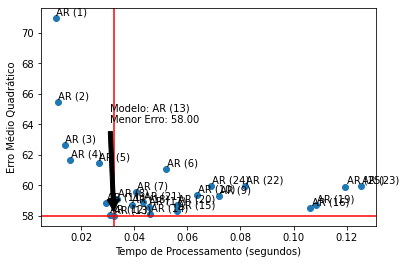

In [75]:
# Identifica o melhor modelo AR
import numpy as np
import matplotlib.pyplot as plt

errors = ar['error_list']
proc_times = ar['proc_time_list']
n = [f"{ar['model']} ({order})" for order in ar['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")
    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, txt in enumerate(n):
    ax.annotate(txt, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.003))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_ar['model']} ({best_ar['best_order']})\nMenor Erro: {best_ar['best_error']:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.955, errors[i]*1.105), 
                    arrowprops=dict(facecolor='black', shrink=0.05))

/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATIO

25.207386564004008

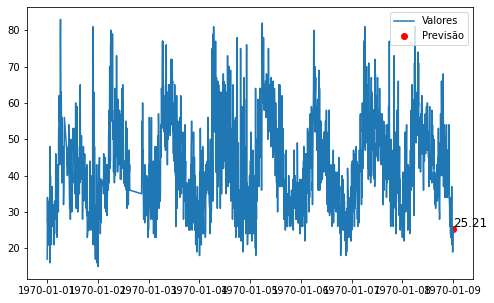

In [76]:
# Análise preditiva utilizando o modelo AR
def predict(serie, order, plot=False):
    model = AR(serie).fit(order)
    next_period = serie.index[-1] + pd.Timedelta('5 minute')
    predict = model.predict(
        start=next_period, 
        end=next_period)
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(
            serie.index[-1], 
            predict[0], 
            color='red')
        plt.text(serie.index[-1], 
                 predict[0]*1.025 , 
                 f'{predict[0]:.2f}', 
                 fontsize=12)
        plt.legend(['Valores', 'Previsão'])
    return predict[0]
predict(dataframe('loaded_m_3330.csv').cpu, 13, plot=True)

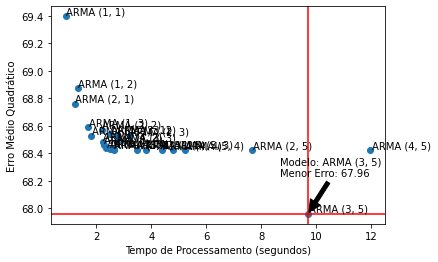

In [77]:
# Identifica o melhor modelo ARMA
import numpy as np
import matplotlib.pyplot as plt

errors = arma['error_list']
proc_times = arma['proc_time_list']
models = [f"{arma['model']} {order}" for order in arma['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")
    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.0002))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_arma['model']} {best_arma['best_order']}\nMenor Erro: {best_arma['best_error']:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.895, errors[i]*1.004), 
                    arrowprops=dict(facecolor='black', shrink=0.05))


25.108699497969518

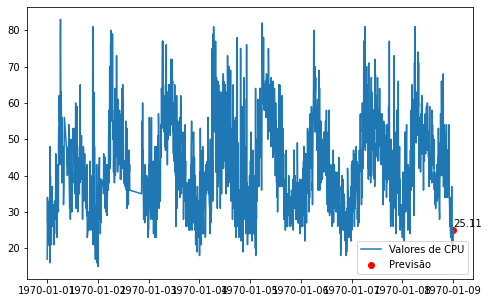

In [78]:
# Análise preditiva utilizando o modelo ARMA
def predict(serie, order, plot=False):
    model = ARMA(serie, freq='5T', order=order).fit()
    forecast = model.forecast()[0][0]
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(serie.index[-1], 
                    forecast, color='red')
        plt.text(serie.index[-1], 
                 forecast*1.035, f'{forecast:.2f}')
        plt.legend(['Valores de CPU', 'Previsão'])
    return forecast
predict(dataframe('loaded_m_3330.csv').cpu, (3, 5), plot=True)

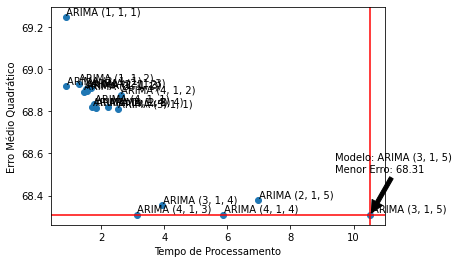

In [79]:
# Identifica o melhor modelo ARIMA
import numpy as np
import matplotlib.pyplot as plt

errors = arima['error_list']
proc_times = arima['proc_time_list']
models = [f"{arima['model']} {order}" for order in arima['order_list']]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento")
plt.ylabel("Erro Médio Quadrático")

    
best_error = min(errors)
#pos_x = min(z)
for e, t in zip(errors,proc_times):
    if e == best_error:
        proc_time = t
plt.axhline(y=best_error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')


for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.0002))
    if errors[i] == best_error:
        ax.annotate(f"Modelo: {best_arima['model']} {best_arima['best_order']}\nMenor Erro: {best_arima['best_error']:.2f}",
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*0.895, errors[i]*1.003), 
                    arrowprops=dict(facecolor='black', shrink=0.05))


/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/danilo/dev/python/alibaba/.alibaba/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa

24.136507265920006

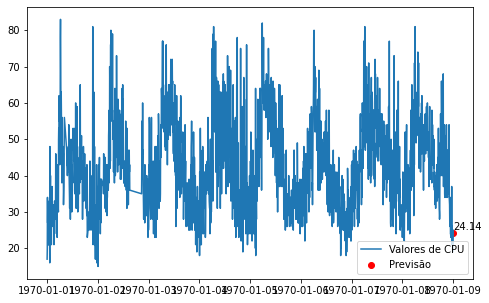

In [80]:
# Análise preditiva utilizando o modelo ARIMA
def predict(serie, order, plot=False):
    model = ARIMA(serie, freq='5T', order=order).fit()
    forecast = model.forecast()[0][0]
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(serie)
        plt.scatter(serie.index[-1], 
                    forecast, color='red')
        plt.text(serie.index[-1], 
                 forecast*1.035, f'{forecast:.2f}')
        plt.legend(['Valores de CPU', 'Previsão'])
    return forecast
predict(dataframe('loaded_m_3330.csv').cpu, (3, 1, 5), plot=True)

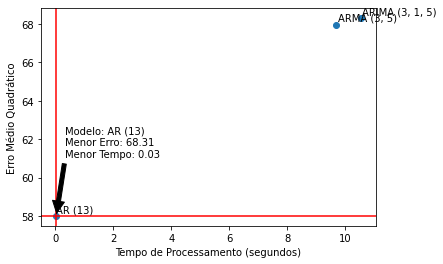

In [81]:
# Identifica o modelo mais eficiente dentre os melhores modelos AR, ARMA e ARIMA
import numpy as np
import matplotlib.pyplot as plt

orders = [best_ar['best_order'], best_arma['best_order'], best_arima['best_order']]
errors = [best_ar['best_error'], best_arma['best_error'], best_arima['best_error']]
proc_times = [best_ar['best_time'], best_arma['best_time'], best_arima['best_time']]
models = [f"{best_ar['model']} ({best_ar['best_order']})", f"{best_arma['model']} {best_arma['best_order']}", f"{best_arima['model']} {best_arima['best_order']}"]

fig, ax = plt.subplots()
ax.scatter(proc_times, errors)

plt.xlabel("Tempo de Processamento (segundos)")
plt.ylabel("Erro Médio Quadrático")

    
best_time = min(proc_times)
#pos_x = min(z)
for m, o, e, t in zip(models,orders,errors,proc_times):
    if t == best_time:
        model = m
        order = o
        error = e
        proc_time = t
plt.axhline(y=error, color='r', linestyle='-')
plt.axvline(x=proc_time, color='r', linestyle='-')

for i, model in enumerate(models):
    ax.annotate(model, xy=(proc_times[i], errors[i]), xytext=(proc_times[i]*1.005, errors[i]*1.003))
    if proc_times[i] == best_time:
        ax.annotate(f"Modelo: {model}\nMenor Erro: {best_error:.2f}\nMenor Tempo: {best_time:.2f}", 
                    xy=(proc_times[i], errors[i]), 
                    xytext=(proc_times[i]*10.515, errors[i]*1.053), 
                    arrowprops=dict(facecolor='black', shrink=0.05))
